In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os

In [3]:
adata = sc.read_h5ad("./merged_raw_postQC.h5ad")

In [4]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.

    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [5]:
### Change directory 
    
CWD = "/Users/jamrute/Desktop/"

from os import chdir
chdir(CWD)

In [7]:
adata.obs['condition'].unique()

array(['LV', 'Tumor'], dtype=object)

Ctrl


Trying to set attribute `.obs` of view, copying.
/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pd1


Trying to set attribute `.obs` of view, copying.
/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


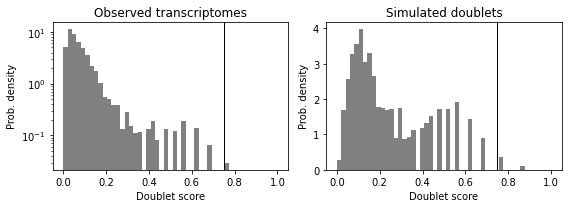

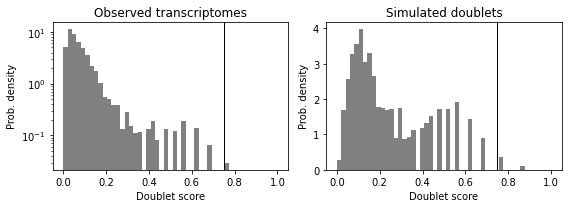

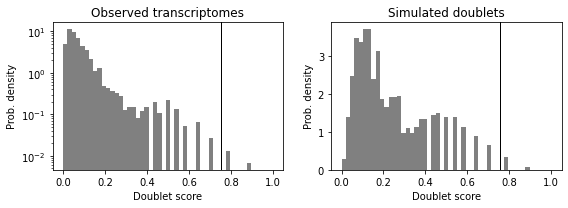

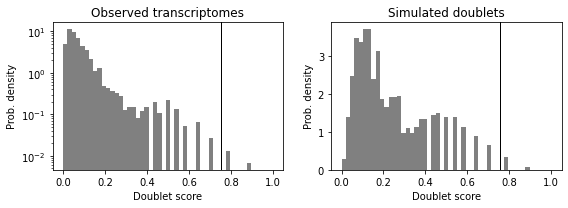

In [6]:
####### main
meta = adata.obs
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)

scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
os.makedirs('scrublet-scores')

###

for sample in meta['condition'].unique():
    print(sample)
    #import data
    adata_sample = adata[adata.obs['condition'] == sample]
    
    #set up and run Scrublet
    scrub = scr.Scrublet(adata_sample.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    scrub.plot_histogram();
    adata_sample.obs['scrublet_score'] = doublet_scores
    #overcluster prep. run turbo basic scanpy pipeline
    sc.pp.filter_genes(adata_sample, min_cells=3)
    sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample)
    sc.pp.highly_variable_genes(adata_sample, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample = adata_sample[:, adata_sample.var['highly_variable']]
    sc.pp.scale(adata_sample, max_value=10)
    sc.tl.pca(adata_sample, svd_solver='arpack')
    sc.pp.neighbors(adata_sample)
    #eoverclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample)
    for clus in np.unique(adata_sample.obs['louvain']):
        sc.tl.louvain(adata_sample, restrict_to=('louvain',[clus]))
        adata_sample.obs['louvain'] = adata_sample.obs['louvain_R']
    #compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample.obs['louvain']):
        adata_sample.obs.loc[adata_sample.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample.obs.loc[adata_sample.obs['louvain']==clus, 'scrublet_score'])
    #now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample.obs['scrublet_cluster_score'])
    mask = adata_sample.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample.obs['scrublet_cluster_score'][mask]-med)
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample.obs['bh_pval'] = bh(pvals)
    #create results data frame for single sample and copy stuff over from the adata object
    scrublet_sample = pd.DataFrame(0, index=adata_sample.obs_names, columns=scorenames)
    for meta in scorenames:
        scrublet_sample[meta] = adata_sample.obs[meta]
    #write out complete sample scores
    scrublet_sample.to_csv('scrublet-scores/'+sample+'.csv')
    scrub.plot_histogram()

In [7]:
adata.obs['condition'].unique()

array(['Ctrl', 'Pd1'], dtype=object)

In [8]:
scrub1 = pd.read_csv("scrublet-scores/Ctrl.csv", index_col=0)
scrub2 = pd.read_csv("scrublet-scores/Pd1.csv", index_col=0)

In [9]:
df_list = [scrub1, scrub2]
scrub_all = pd.concat(df_list)
scrub_all

,scrublet_score,scrublet_cluster_score,bh_pval
AAACCCAAGCACGTCC-1_1,0.181818,0.079332,0.908312
AAACCCAAGCATGATA-1_1,0.050289,0.066038,0.957205
AAACCCAAGTCAGAGC-1_1,0.032391,0.032391,0.973701
AAACCCAAGTGAGCCA-1_1,0.012372,0.018757,0.973701
AAACCCACAGTAACCT-1_1,0.048780,0.068073,0.957205
...,...,...,...
TTTGTTGAGGAATGTT-1_2,0.073403,0.085062,0.917474
TTTGTTGAGGTCGCCT-1_2,0.046177,0.098976,0.917474
TTTGTTGAGTCAGAGC-1_2,0.016234,0.014548,0.917474
TTTGTTGCAACGTATC-1_2,0.073403,0.073403,0.917474


In [10]:
scrub_all.to_csv('scrublet-scores/all.csv')